In [1]:
"""
TODO: 

Implement linear system class for managing state transition.
Tune process and measurement covariance.
"""

'\nTODO: \n\nImplement linear system class for managing state transition.\nTune process and measurement covariance.\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import multi_dot
from numpy.random import multivariate_normal
np.random.seed(21)

In [3]:
# Notation

# A: n x n, state transition
# H: m x n, measurement viewpoint
# K: n x m, kalman gain
# P: n x n, error covariance
# R: n x n, process covariance

# x: n x 1, state
# w: n x 1, process noise
# v: n x 1, measurement noise

In [82]:
class LinearSystem:
    
    def __init__(self, n, m, x0, A, H, R, Q):
        self.n = n
        self.m = m
        self.x = x0
        self.A = A
        self.H = H
        self.R = R
        self.Q = Q
        
    def forward(self):
        state_transition = self.A @ self.x
        process_noise = multivariate_normal(np.zeros(self.n), self.Q)
        self.x = state_transition + process_noise
        
    def measurement(self):
        measurement_noise = multivariate_normal(np.zeros(m), self.R)
        self.z = self.H @ self.x + measurement_noise

In [83]:
class Kalman:
    
    def __init__(self, n, m, sys):
        self.linear_system = sys
        self.n = n
        self.m = m
        self.K = np.zeros((n, m))
        self.P = np.eye(n)
        self.x_est = np.zeros(n)
        
    def update_kalman_gain(self):
        sys = self.linear_system
        prod = multi_dot((sys.H, self.P, sys.H.T))
        inv = np.linalg.pinv(prod + sys.R)
        self.K = multi_dot((self.P, sys.H.T, inv))

    def update_estimate(self):
        sys = self.linear_system
        innovation = sys.z - sys.H @ self.x_est
        self.x_est = self.x_est + self.K @ innovation
    
    def update_covariance(self):
        H = self.linear_system.H
        I = np.eye(self.n)
        self.P = (I - self.K @ H) @ self.P
        
    def project_ahead(self):
        sys = self.linear_system
        self.x_est = sys.A @ self.x_est
        self.P = multi_dot((sys.A, self.P, sys.A.T)) + sys.Q
        
    def loop(self):
        self.linear_system.forward()
        self.linear_system.measurement()
        
        self.update_kalman_gain()
        self.update_estimate()
        self.update_covariance()
        self.project_ahead()

In [84]:
A = np.random.rand(n, n)
H = np.random.rand(m, n)
R = np.eye(m)
Q = np.eye(n)
x0 = [-1, 1.5]

In [125]:
n = 2
m = 2

A = np.array([
    [0.9, 0.2], 
    [-0.3, 0.5]
])

H = 1.3 * np.eye(m)
R = 0.5 * np.eye(m)
Q = 1.4 * np.eye(n)

x0 = [-0.7, 0.9]

sys = LinearSystem(n, m, x0, A, H, R, Q)
kalman = Kalman(n, m, sys)

In [132]:
num_iters = 100

x = []
x_est = []
 
for i in range(num_iters):
    x.append(kalman.linear_system.x)
    x_est.append(kalman.x_est)
    kalman.loop()

x = np.array(x)
x_est = np.array(x_est)

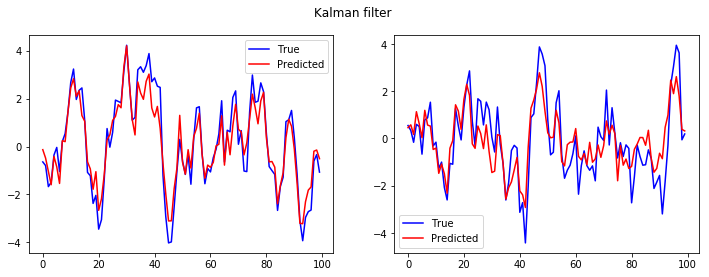

In [133]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

for a, xi, xi_est in zip(ax, x.T, x_est.T):
    a.plot(xi, 'blue')
    a.plot(xi_est, 'red')
    a.legend(['True', 'Predicted'])
    
fig.suptitle('Kalman filter')
plt.show()